# Open Data From JSON

In [12]:
import pandas as pd
import numpy as np
import glob

In [13]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


# Amount of articles that will be processed:

In [14]:
len(df["maintext"])

653

# Preprocessing 

In [15]:
import re

In [16]:
df['id'] = df.index
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2


In [17]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

In [18]:
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)

for element in df["tokenized_words"]:
        	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

df["maintext_nouns"] = nouns

In [20]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...


# Word Cloud

In [85]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Word Cloud All Words

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


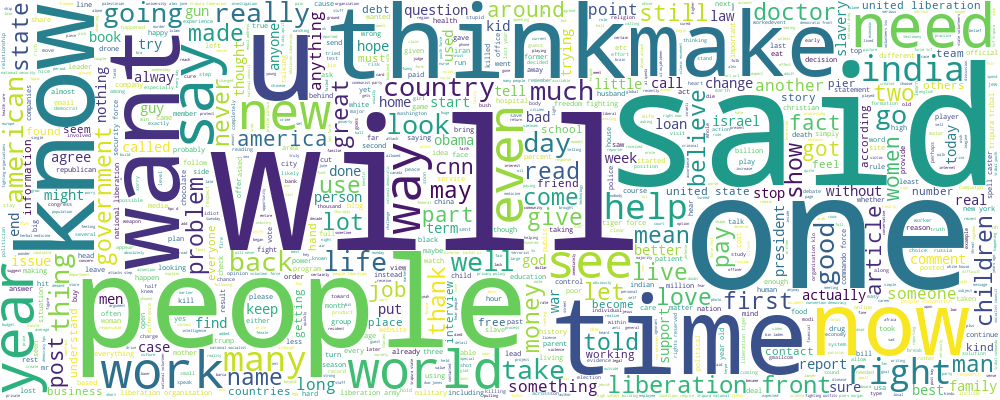

In [87]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


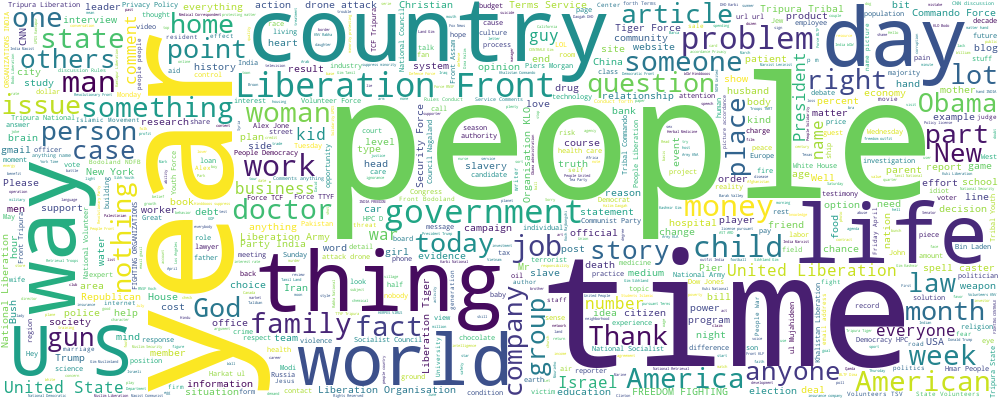

In [89]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

In [91]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [158]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [159]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [160]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [161]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
df["maintext_ready"]  = maintext_ready

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [162]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...",7,0.99551,"country, india, world, woman, right, life, pro..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(2, 16), (20, 1), (36, 1), (37, 2), (68, 1), ...",8,0.99851,"liberation, force, tripura, national, india, u..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(11, 4), (16, 1), (20, 1), (22, 1), (36, 1), ...",6,0.99760,"country, india, world, child, life, school, fa..."


# Wordcloud of the ready-to-cluster articles

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


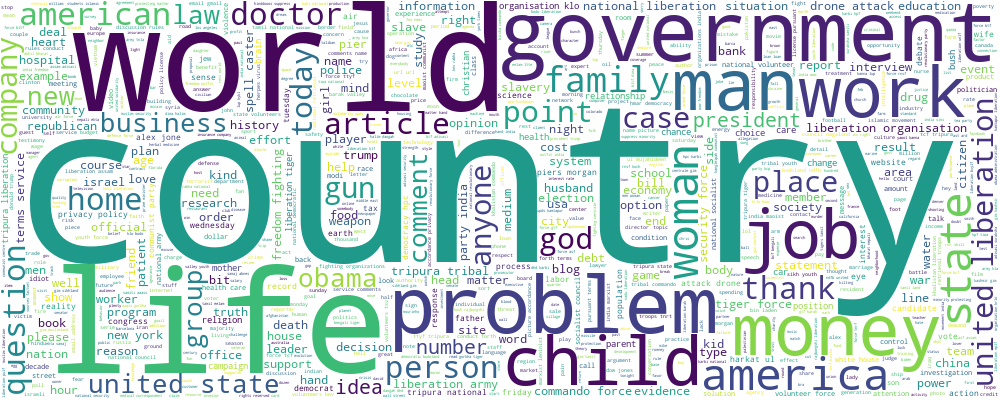

In [163]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

In [164]:
import gensim.corpora as corpora

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [165]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [166]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...",7,0.99551,"country, india, world, woman, right, life, pro..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(2, 16), (20, 1), (36, 1), (37, 2), (68, 1), ...",8,0.99851,"liberation, force, tripura, national, india, u..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(11, 4), (16, 1), (20, 1), (22, 1), (36, 1), ...",6,0.99760,"country, india, world, child, life, school, fa..."


# Build a LDA model (need to find fitting values here)

In [167]:
from pprint import pprint   #pretty printing

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [168]:
amount_of_topics = 10  #adjust to find good results

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [169]:
lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics)   #build the LDA model

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Displaying the LDA model

In [170]:
pprint(lda_model.print_topics())
articles_lda = lda_model[corpus]

[(0,
  '0.009*"force" + 0.008*"liberation" + 0.007*"loan" + 0.006*"tripura" + '
  '0.006*"world" + 0.006*"india" + 0.005*"country" + 0.004*"national" + '
  '0.004*"life" + 0.004*"school"'),
 (1,
  '0.006*"world" + 0.005*"country" + 0.004*"israel" + 0.004*"child" + '
  '0.004*"state" + 0.003*"india" + 0.003*"money" + 0.003*"school" + '
  '0.003*"job" + 0.003*"life"'),
 (2,
  '0.005*"country" + 0.004*"world" + 0.004*"child" + 0.004*"life" + '
  '0.003*"liberation" + 0.003*"state" + 0.003*"force" + 0.003*"india" + '
  '0.003*"united" + 0.003*"school"'),
 (3,
  '0.004*"liberation" + 0.004*"force" + 0.004*"country" + 0.004*"government" + '
  '0.004*"life" + 0.003*"problem" + 0.003*"child" + 0.003*"obama" + '
  '0.003*"world" + 0.003*"united"'),
 (4,
  '0.006*"country" + 0.005*"world" + 0.005*"life" + 0.004*"president" + '
  '0.004*"india" + 0.004*"trump" + 0.003*"state" + 0.003*"money" + '
  '0.003*"problem" + 0.003*"child"'),
 (5,
  '0.007*"force" + 0.006*"tripura" + 0.006*"liberation" + 0

# Visualize the LDA model for further analysis (needed to find the best values to adjust)

In [171]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from IPython.display import HTML, display

pyLDAvis.enable_notebook()

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [172]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.035024  0.013332       1        1  17.671376
3      0.001774  0.011186       2        1  12.087109
4      0.023589 -0.005295       3        1  12.033879
8     -0.039327  0.018225       4        1  11.542727
2      0.009565 -0.001085       5        1  10.528048
1      0.035464 -0.007634       6        1   9.403078
0     -0.020428 -0.006991       7        1   7.932942
7     -0.040777 -0.012312       8        1   6.748755
6      0.005322 -0.006770       9        1   6.645075
5     -0.010207 -0.002656      10        1   5.407010, topic_info=            Term         Freq        Total Category  logprob  loglift
370   liberation  1571.000000  1571.000000  Default  30.0000  30.0000
268        force  1751.000000  1751.000000  Default  29.0000  29.0000
517      tripura  1202.000000  1202.000000  Default  28.0000  28.0000
405     national  1147.000000  1147.000000  Default  27.0000  27.0000
1957        loan   653.000000   653.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1173  government    41.992235   896.754745  Topic10  -6.1008  -0.1438
68          life    44.245492  1216.007726  Topic10  -6.0485  -0.3961
5249         gun    38.082248   711.914483  Topic10  -6.1986  -0.0107
727        money    37.079334   876.692618  Topic10  -6.2252  -0.2456
105        right    36.649511   784.513137  Topic10  -6.2369  -0.1462

[865 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
10615      1  0.109205  abbottabad
10615      2  0.109205  abbottabad
10615      3  0.109205  abbottabad
10615      4  0.436820  abbottabad
10615      5  0.109205  abbottabad
...      ...       ...         ...
23521      8  0.692896        zeya
11598      3  0.607631     zoodles
11598      4  0.202544     zoodles
11599      3  0.604967    zucchini
11599      4  0.201656    zucchini

[3076 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 5, 9, 3, 2, 1, 8, 7, 6])

# Store Cluster IDs to dataframe

In [173]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

for i, row in enumerate(articles_lda):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):   #get the dominant topic for each article
            if j == 0:  #dominant topic (only first one)
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_list.append(int(topic_num))
                topic_percentage_list.append(round(prop_topic,5))
                topic_keywords_list.append(topic_keywords)
            else: 
                break

df["clusterID"] = topic_list    ##the id of the topic
df["topic_percentage"] = topic_percentage_list  #how well the topic fits
df["topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [174]:
df.head(50)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...",5,0.81814,"force, tripura, liberation, national, world, p..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(2, 16), (20, 1), (36, 1), (37, 2), (68, 1), ...",7,0.68338,"force, national, liberation, tripura, india, u..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(11, 4), (16, 1), (20, 1), (22, 1), (36, 1), ...",8,0.99760,"liberation, force, tripura, india, national, u..."
3,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 15:53:08",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,3,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(6, 1), (11, 5), (20, 1), (26, 3), (36, 1), (...",8,0.99715,"liberation, force, tripura, india, national, u..."
4,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 17:20:20",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,4,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(5, 1), (19, 1), (20, 2), (26, 1), (28, 6), (...",8,0.99793,"liberation, force, tripura, india, national, u..."
5,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 15:36:52",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,5,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(20, 1), (26, 1), (36, 1), (37, 2), (46, 1), ...",8,0.99726,"liberation, force, tripura, india, national, u..."
6,"06/30/2021, 22:17:27","06/30/2021, 22:17